# Projeto 1 - Ciência dos Dados
## Classificador Naive Bayes

Nome: Pedro Cliquet Amaral

Nome: Luciano Felix Dias

## Etapa 2 - Construção de um modelo de classificação

---
## 1) Preparando o ambiente no Jupyter:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from numpy import random

---
## 2) Carregando a base de dados

In [3]:
filename = 'League of Legends_1.xlsx'

In [4]:
train = pd.read_excel(filename, sheet_name = 'Treinamento')
train.head(5)

,Tweets,Relevancia
0,@aakkari @furia tem um champ no league of lege...,0
1,@raylerchil @noideapraisso @paulokogos_ofc kkk...,0
2,a faculdade ta atrapalhando meu desempenho no ...,1
3,league of legends é pior do que perder q vida ...,1
4,eu te odeio league of legends lixo de jogo lixo,1


In [5]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Tweets,Relevancia
0,uma call do supermercado vendo anime e a outra...,0
1,#pulgapreta #leagueoflegends #nimotv pulgapret...,0
2,"fico de cara que vem uns zé buceta fala ""ah ma...",0
3,@hastadvalorant esquece league of legends e ba...,0
4,saudade de jogar league of legends com elas,1


___
## 3) Modelo de classificação


### 3.1) Cleaner

In [6]:
def normalize (text):
    """
        Função que normaliza os caracteres dos tweets.
    """
    text_lower = text.lower()
    matches = [
        R"[!-.\:\;\"\'/\\]",         # Pontuações
        R"\b\w{,2}\b",               # Palavras curtas
        R"[@#]\S+",                  # Marcações e Hashtags
        R"https?:\/\/\S+|www.\S+"    # Links
    ]
    match_pattern = "|".join(matches)
    pattern = re.compile(match_pattern)
    normalized = re.sub(pattern, '', text_lower)
    return normalized

### 3.2) Dicionário de palavras

In [7]:
def extract_words (series):
    """
        Função que extrai as palavras de uma Series.
    """
    split = [line.split() for line in series]
    words = [word for line in split for word in line]
    
    return pd.Series(words)


### 3.3) Naive Bayes

In [8]:
def P_palavra (palavra, dicio, length):
    """
        Função que calcula a probabilidade de uma palavra dado um dicionário de palavras com suavização por Naive-Bayes.
    """
    ocor = dicio[palavra] if palavra in dicio else 0
    prob = (ocor + 1) / (length + len(dicio))

    return prob


### 3.4) Classificador

In [9]:
class classificador:
    def __init__ (self, df, data_column, category_column):
        self.columns = (data_column, category_column)

        data = df[data_column]
        words = extract_words(data)
        self.length = len(words)

        categories = df[category_column].cat.categories

        self.categories = {}
        for category in categories:
            cat_filter = df[category_column] == category
            filtered = df.loc[cat_filter]
            data = filtered[data_column]
            words = extract_words(data)

            self.categories[category] = {
                "table": words.value_counts(),
                "length": len(words)
            }
    
    def probabilidades (self, frase):
        normalized = normalize(frase)
        
        P_list = []
        for category, data in self.categories.items():
            table = data["table"]
            length = data["length"]
            
            P_cat = length / self.length
            P_frase_dado_cat = 1

            for palavra in normalized.split():
                P = P_palavra(palavra, table, length)
                P_frase_dado_cat *= P

            P_cat_dado_frase = P_frase_dado_cat * P_cat
            P_list.append((category, P_cat_dado_frase))

        return pd.DataFrame(P_list, columns=self.columns)

    def classifica (self, frase):
        sorted_prob = self.probabilidades(frase).sort_values(by="Relevancia", ascending=False)

        return sorted_prob.iloc[0, 0]


---
## 4) Treinamento do modelo

### 4.1) Normalização e categorização da base de dados de treinamento

In [10]:
# Normalização dos tweets
train["Tweets"] = train["Tweets"].apply(normalize)

# Criação das categorias de relevância
train.Relevancia = train.Relevancia.astype("category")
train.Relevancia.cat.categories = ["Irrelevante","Relevante"]

train

,Tweets,Relevancia
0,tem champ league legends que chama akali...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
2,faculdade atrapalhando meu desempenho leagu...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
...,...,...
295,não sei continuo jogando esse jogo desgraça...,Relevante
296,larguei league legends vou voltar virar gente,Relevante
297,odeio league legends,Relevante
298,esse league legends uma puta pediu pra atual...,Relevante


In [11]:
relevante = train["Relevancia"] == "Relevante"
train_R = train.loc[relevante]

train_R.head()

,Tweets,Relevancia
2,faculdade atrapalhando meu desempenho leagu...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
7,league legends jogo podre nojento,Relevante
8,vezes acho que fato não poder jogar league...,Relevante


In [12]:
irrelevante = train["Relevancia"] == "Irrelevante"
train_I = train.loc[irrelevante]

train_I.head()

,Tweets,Relevancia
0,tem champ league legends que chama akali...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
5,unico defeito kim heechul ser diamante jog...,Irrelevante
6,league legends segredos para chegar mestre ...,Irrelevante
10,vivo jogando league legends,Irrelevante


### 4.2) Aplicação do modelo classificador

In [13]:
classificador_tweets_lol = classificador(train, "Tweets", "Relevancia")

### 4.3) Verificação dos dicionários

In [14]:
{cat: val["length"] for cat, val in classificador_tweets_lol.categories.items()}

{'Irrelevante': 2491, 'Relevante': 1286}

### 4.4) Teste unitário

In [15]:
frase = "lalaaaa bib tsd"

P_frase = classificador_tweets_lol.probabilidades(frase)

P_frase.sort_values(by="Relevancia", ascending=False).head()

,Tweets,Relevancia
1,Relevante,5.248769e-11
0,Irrelevante,1.467939e-11


---
## 5) Teste to modelo

### 5.1) Normalização, categorização e verificação da base de dados de teste

In [16]:
# Normalização dos tweets
test["Tweets"] = test["Tweets"].apply(normalize)

# Criação das categorias de relevância
test.Relevancia = test.Relevancia.astype("category")
test.Relevancia.cat.categories = ["Irrelevante","Relevante"]

# Verificação da base de dados utilizando o modelo de classificção
test["Verifica"] = test["Tweets"].apply(classificador_tweets_lol.classifica)

test["Acerto"] = test["Verifica"] == test["Relevancia"]
test["Acerto"] = test["Acerto"].astype("category")
test["Acerto"].cat.categories = ["Errou", "Acertou"]

test

,Tweets,Relevancia,Verifica,Acerto
0,uma call supermercado vendo anime outra jog...,Irrelevante,Relevante,Errou
1,pulgapreta leagueoflegends nimotv pulgapreta e...,Irrelevante,Irrelevante,Acertou
2,fico cara que vem uns buceta fala mas tan...,Irrelevante,Relevante,Errou
3,esquece league legends baixa algum moba ce...,Irrelevante,Relevante,Errou
4,saudade jogar league legends com elas,Relevante,Relevante,Acertou
...,...,...,...,...
195,depois assalto valença que levaram meu celul...,Relevante,Relevante,Acertou
196,time league legends furb dos lineups fur...,Irrelevante,Relevante,Errou
197,mal vejo hora chegar casa pra jogar aquele ...,Relevante,Relevante,Acertou
198,como bom xingar jogo league legends,Relevante,Relevante,Acertou


___
## 6) Verificando a performance do Classificador

In [17]:
pd.crosstab(test["Relevancia"], test["Acerto"], normalize=True)

Acerto,Errou,Acertou
Relevancia,,
Irrelevante,0.470,0.075
Relevante,0.005,0.450


___
### 7) Conclusão

* nosso classificador errou muito
* como o classificador apenas classifica como relevante e irrelevante a partir das nossas avaliações manuais do arquivo excel, ele não identifica sarcasmo e dupla negação. Entretanto, pelo formato de classificação ser binário, as caracteristicas desses comentário são irrelevantes na hora da maquina classificar.
* Uma proposta de melhoria seria adotar as caracteristicas citadas acima, e também dar importancia para a ordem das palavras. Assim a maquina poderá iterar e classificar comentários de uma forma mais realista.
* Classificar email como spam(aberto)
* Interpretação de texto via machine learning
* Por que eles devem continuar financiando o seu projeto? por que ao expandir a forma do classificador no questio interpretação, podemos identificar eventuais problemas que os consumidores estão passando, ou pontos que mantem-os como fieis jogadores. E isso pode ajudar nas melhorias a longo prazo, e quissá, trazer novos players com os feedbacks positivos que a empresa terá ROUBANDO DADOS DA GALERA PELO TWITI!

___
## 8) Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

### 8.1) Fusão da base de dados

In [18]:
assert_train = pd.read_excel(filename, sheet_name = "Treinamento")
assert_test = pd.read_excel(filename, sheet_name = "Teste")
assert_df = pd.concat([assert_train, assert_test], ignore_index=True)

assert_df["Tweets"] = assert_df["Tweets"].apply(normalize)

assert_df["Relevancia"] = assert_df["Relevancia"].astype("category")
assert_df["Relevancia"].cat.categories = (["Irrelevante","Relevante"])

assert_df

,Tweets,Relevancia
0,tem champ league legends que chama akali...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
2,faculdade atrapalhando meu desempenho leagu...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
...,...,...
495,depois assalto valença que levaram meu celul...,Relevante
496,time league legends furb dos lineups fur...,Irrelevante
497,mal vejo hora chegar casa pra jogar aquele ...,Relevante
498,como bom xingar jogo league legends,Relevante


### 8.2) Embaralhamento e divisão da base de dados, Treinamento e teste do modelo de classificação

In [19]:

acerto_R_list = []
acerto_I_list = []
erro_R_list   = []
erro_I_list   = []

for i in range(100):
    df_permute    = assert_df.reindex(random.permutation(assert_df.index))
    permute_test  = df_permute.iloc[0:200]
    permute_train = df_permute.iloc[200:500]

    classificador_tweets_lol = classificador(permute_train, "Tweets", "Relevancia")
    permute_test["verifica"] = permute_test["Tweets"].apply(classificador_tweets_lol.classifica)

    hits = permute_test["verifica"] == permute_test["Relevancia"]
    cross_table = pd.crosstab(permute_test["verifica"], hits, normalize=True)

    acerto_R = cross_table.loc["Relevante", True]
    acerto_I = cross_table.loc["Irrelevante", True]
    erro_R   = cross_table.loc["Relevante", False]
    erro_I   = cross_table.loc["Irrelevante", False]

    acerto_R_list.append(acerto_R)
    acerto_I_list.append(acerto_I)
    erro_R_list.append(erro_R)
    erro_I_list.append(erro_I)

<ipython-input-19-c8931832cb8e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permute_test["verifica"] = permute_test["Tweets"].apply(classificador_tweets_lol.classifica)


### 8.3) Gráficos conclusivos da qualidade do modelo

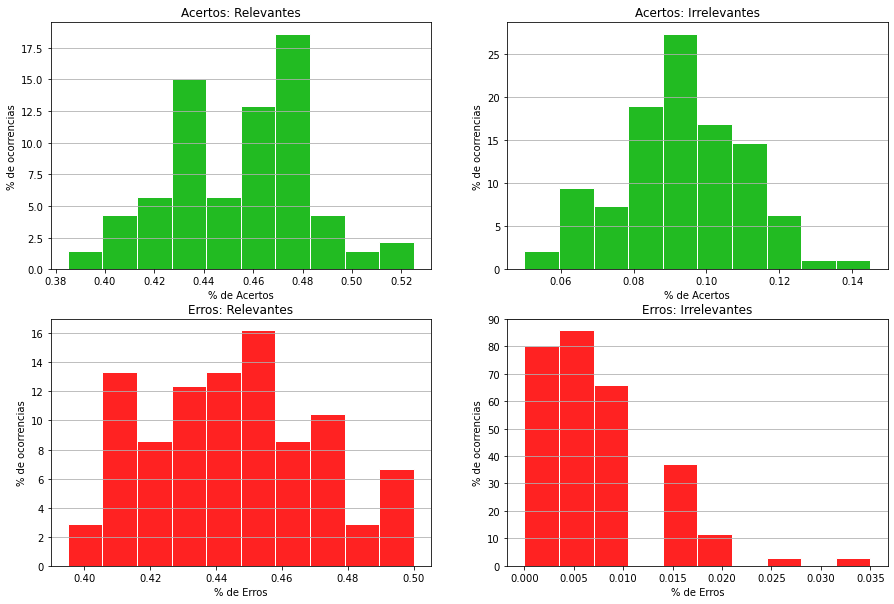

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(acerto_R_list, color="#22BB22", edgecolor="w", density=True)
plt.title("Acertos: Relevantes")
plt.xlabel("% de Acertos")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.subplot(2, 2, 2)
plt.hist(acerto_I_list, color="#22BB22", edgecolor="w", density=True)
plt.title("Acertos: Irrelevantes")
plt.xlabel("% de Acertos")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.subplot(2, 2, 3)
plt.hist(erro_R_list, color="#FF2222", edgecolor="w", density=True)
plt.title("Erros: Relevantes")
plt.xlabel("% de Erros")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.subplot(2, 2, 4)
plt.hist(erro_I_list, color="#FF2222", edgecolor="w", density=True)
plt.title("Erros: Irrelevantes")
plt.xlabel("% de Erros")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.savefig('plots/qualidade.png', dpi=300)
plt.show()

___
## 9) Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


___
## 10) Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/)